In [1]:
# My stuff
from utils.training import DataGenerator, Engine, plot_results, make_model

# Tensorflow and Keras stuff
from keras.optimizers import Adam, Adadelta
from keras.callbacks import ModelCheckpoint
from keras import backend as K


# Modelling and Metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve,
                             f1_score, auc, average_precision_score, matthews_corrcoef, recall_score, precision_score)

# Regular stuff
import os
import numpy as np
import pandas as pd



Using TensorFlow backend.


In [2]:
# Helper functions and classes 
    
class ModelMetrics():
    """
        ModelMetrics class that will provide many different metrics for a given model outputs. 

        Required Parameters:
        y_test = Test Data Classes. Should be either (-1,1) or (0,1).
        y_pred = Predictions for the "probability" of y being in the positive class. Should be in range (-inf,inf)
        y_prob = Test Data Predictions from the model. Should be same format as y_test. 

        Useful functions:
        all_metrics() = returns metrics including: class imbalance, 
                                                   accuracy,
                                                   confusion matrix,
                                                   ROC/AUC,
                                                   Precision/Recall Curve, F1 score, MCC, AUC, Average Precision
        
    """
    
    def __init__(self,y_test,y_pred,y_prob):
        self.y_test = np.array(y_test).reshape(-1)
        self.y_pred = np.array(y_pred).reshape(-1)
        self.y_prob = np.array(y_prob).reshape(-1)
        
    def all_metrics(self):
        print('')
        self.imbalance()
        print('')
        self.accuracy()
        print('')
        self.print_cm()
        print('')
        self.roc_metrics()
        print('')
        self.pr_metrics()
        
    def roc_metrics(self):
        self.roc_plot()
        self.print_auc_roc()
        
    def pr_metrics(self):
        self.plot_pr()
        self.print_f1()
        self.print_mcc()
        self.print_auc_pr()
        self.print_ap()
        
    # Measure Imbalance
    def imbalance(self):
        num_examples = len(self.y_test)
        y_min = min(self.y_test)
        y_max = max(self.y_test) 
        num_neg = np.sum(self.y_test==y_min)
        num_pos = np.sum(self.y_test==y_max)
        print("Number of negative cases = ",num_neg)
        print("Number of positive cases = ",num_pos)
        print('The ratio of Positve to Negative cases is {:0.3f}'.format(num_pos/num_neg))
        
        print('')
        if num_neg/num_pos >= 2:
            print('Number of Negative Classes is quite large. Recommend using the Precision-Recall Metrics.')
        elif num_pos/num_neg >=2:
            print('Number of Positive Classes is quite large. Recommend using the Precision-Recall Metrics.')
        else:
            print('The classes seem balanced. ROC metrics should be acceptable.')
        print('')
    
    # Overall accuracy
    def accuracy(self):
        acc = accuracy_score(self.y_test,self.y_pred)
        print('Overall Accuracy = {:0.3f}'.format(acc))
        return acc
        
    # Confusion Matrix
    def print_cm(self):
        cm = confusion_matrix(self.y_test,self.y_pred)
        true_negative, false_positive, false_negative, true_positive = cm.ravel()
        print('           CONFUSION MATRIX')
        print('                 y_pred')
        print('          {:^10d}{:^10d}'.format(-1,1))
        print('           --------------------')
        print('y_test -1 |{:^10d}{:^10d}|'.format(true_negative,false_positive))
        print('        1 |{:^10d}{:^10d}|'.format(false_negative,true_positive))
        print('           --------------------')
        return cm
        
    # ROC Curve
    def roc_plot(self):
        false_positive_rate, true_positive_rate, thresholds = roc_curve(self.y_test,self.y_prob)
        plt.plot(false_positive_rate,true_positive_rate,'-b',label='Model')
        plt.plot([0,1],[0,1],'-k',label='Guess')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # AUC of ROC
    def print_auc_roc(self):
        auc1 = roc_auc_score(self.y_test,self.y_prob)
        print('AUC = {:0.3f}'.format(auc1))
        return auc1

    ## These next few are more useful for imbalanced classes 

    # Precision - Recall Curve
    def plot_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        plt.plot(recall,precision,'-b',label='Model')
        plt.plot([0,1],[0.5,0.5],'-k',label='Guess')
        plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim([-0.02,1.0])
        plt.ylim([0.0,1.02])
        plt.legend()
        plt.show()

    # F1 Score
    def print_f1(self):
        f1 = f1_score(self.y_test,self.y_pred)
        print("F1 Score = {:0.3f}".format(f1))
        return f1
    
    # Matthews Correlation
    def print_mcc(self):
        mcc = matthews_corrcoef(self.y_test,self.y_pred)
        print("MCC = {:0.3f}".format(mcc))
        return mcc

    # AUC for PR
    def print_auc_pr(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.y_prob)
        auc2 = auc(recall,precision)
        print("AUC for Precision-Recall: {:0.3f}".format(auc2))
        return auc2

    # Average precision
    def print_ap(self):
        average_precision = average_precision_score(self.y_test,self.y_prob)
        print("Average Precision = {:0.3f}".format(average_precision))
        return average_precision

In [20]:
#K.clear_session()
# Make our model for the cap hit predictions
model_cap = make_model(prediction_type = 'cap_hit', 
                       lstm_layers = [64, 64, 32], 
                       dense_layers= [20, 20, 20],
                       activation = 'relu')

In [3]:
# Import the data to train it with
# Note that I think here we only need the 'matched csv' for contract stats
# The other 2 contain more skaters who haven't necessarily had a standard contract yet
data_gen_cap = DataGenerator('./data/player_stats.csv',
                            './data/contract_stats_matched.csv',
                            './data/game_stats.csv',
                            prediction_type = 'cap_hit',
                            batch_size = 20)

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
# Select an optimizer
optim = Adam()

In [22]:
# Create a training engine
engine_cap = Engine(model=model_cap, 
                    data_generator=data_gen_cap, 
                    optimizer=optim, 
                    prediction_type = 'cap_hit')

Let's have a quick look at what this model actually looks like. 

We have some time series data (every players season before their contract), 
but we also have some data that doesn't change from season to season (position, signing age, how they shoot, etc)

So we'll try a silly model: a LSTM recurrent NN that will join up with the non series data at the end. 

In [47]:
engine_cap.load_model('./models/cap_hit_model_run_noTB')

In [11]:
engine_cap.model_summary(0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 105)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 64)     43520       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 64)     33024       lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 32)           12416       lstm_2[0][0]                     
__________________________________________________________________________________________________
input_2 (I

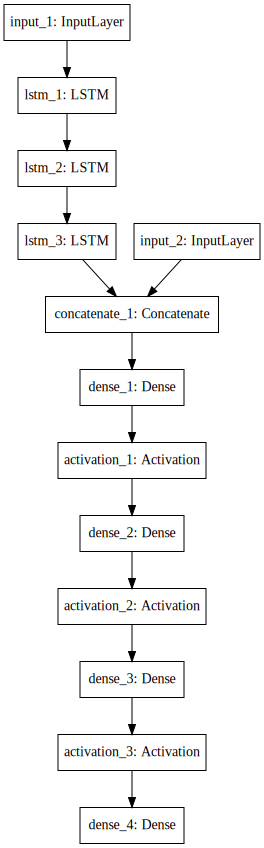

In [9]:
engine_cap.model_summary(1, './figs/cap_hit_model.png')

In [23]:
# Let's run through this once to see how we do
run_id = 'noTB'
engine_cap.fit(epochs=30, early_stopping=True, verbose=1)

Epoch 1/30
120/120 [==============================] - 17s 142ms/step - loss: 7.2708e-04 - val_loss: 3.8408e-04
Epoch 2/30
120/120 [==============================] - 12s 103ms/step - loss: 3.6382e-04 - val_loss: 3.2937e-04
Epoch 3/30
120/120 [==============================] - 13s 112ms/step - loss: 3.0841e-04 - val_loss: 3.6062e-04
Epoch 4/30
120/120 [==============================] - 16s 133ms/step - loss: 2.8622e-04 - val_loss: 2.9613e-04
Epoch 5/30
120/120 [==============================] - 14s 115ms/step - loss: 2.6190e-04 - val_loss: 3.0014e-04
Epoch 6/30
120/120 [==============================] - 14s 116ms/step - loss: 2.3997e-04 - val_loss: 2.7864e-04
Epoch 7/30
120/120 [==============================] - 14s 121ms/step - loss: 2.2503e-04 - val_loss: 2.7528e-04
Epoch 8/30
120/120 [==============================] - 14s 119ms/step - loss: 2.2760e-04 - val_loss: 2.6644e-04
Epoch 9/30
120/120 [==============================] - 15s 124ms/step - loss: 2.1716e-04 - val_loss: 2.6123e-04
E

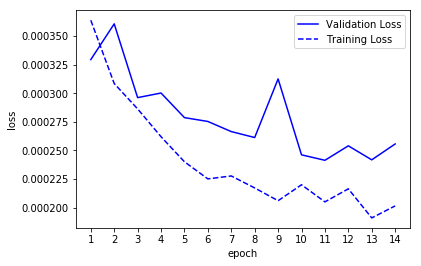

In [24]:
# Look at the loss evolution
engine_cap.plot_history(validation=True, 
                        save_file='./figs/cap_hit_losses_run_{:s}.png'.format(str(run_id)), 
                        display=True)

In [26]:
# Make a prediction for a new player
predict = engine_cap.predict(player_name='Mitchell Marner', 
                   signing_date=(4,7,2019), 
                   signing_status=1, 
                   length=7, 
                   verbose=True)

Current Cap:           81.500 M
Total Contract Value:  65.207 M
Expected Cap Hit:      9.315 M
Percentage of Cap:     11.430 %


In [27]:
# Finally, we can save the model
engine_cap.save_model('models/cap_hit_model_run_{:s}'.format(str(run_id)))

In [29]:
# Now do a bunch of runs with tensorboard on (to look at later, or in real time!), 
# save all the models 
# and get an average estimate for one player
num_models = 20
num_epochs = 50
artemi_avg = np.empty(num_models)
print('Model Prediction for Artemi Panarin: ')
for ii in range(num_models):
    K.clear_session()
    model_cap = make_model(prediction_type = 'cap_hit', 
                           lstm_layers = [64, 64, 32], 
                           dense_layers= [20, 20, 20],
                           activation = 'relu')
    
    optim = Adam()
    
    engine = Engine(model_cap, data_gen_cap, optim, prediction_type = 'cap_hit')
    
    tensorboard=True
    base_dir = 'cap_hit_logs'
    run_id = 'noTB'
    if tensorboard:
        log_dir = os.path.join('./logs', base_dir)
        run_id = len([name for name in os.listdir(log_dir)])
    engine.fit(num_epochs, tensorboard=tensorboard, verbose=0)
    engine.plot_history(True, './figs/cap_hit_losses_run_{:s}.png'.format(str(run_id)), False)
    engine.save_model('models/cap_hit_model_run_{:s}'.format(str(run_id)))
    
    predictions = engine.predict('Artemi Panarin', (4,7,2019), 1, 7, False)
    artemi_avg[ii] = predictions[0]
    
    print('Model: {:d} ** Cap Hit: {:0.3f}'.format(run_id, predictions[0]/1e6))
    
print('Salary Average: {:0.3f}'.format(np.mean(artemi_avg)/1e6))
print('Salary St Dev: {:0.3f}'.format(np.std(artemi_avg)/1e6))

Model Prediction for Artemi Panarin: 
Model: 0 ** Cap Hit: 10.328
Model: 1 ** Cap Hit: 14.332
Model: 2 ** Cap Hit: 9.033
Model: 3 ** Cap Hit: 8.931
Model: 4 ** Cap Hit: 8.706
Model: 5 ** Cap Hit: 10.708
Model: 6 ** Cap Hit: 9.304
Model: 7 ** Cap Hit: 10.739
Model: 8 ** Cap Hit: 9.060
Model: 9 ** Cap Hit: 8.194
Model: 10 ** Cap Hit: 9.981
Model: 11 ** Cap Hit: 7.601
Model: 12 ** Cap Hit: 10.815
Model: 13 ** Cap Hit: 9.167
Model: 14 ** Cap Hit: 10.446
Model: 15 ** Cap Hit: 9.575
Model: 16 ** Cap Hit: 11.232
Model: 17 ** Cap Hit: 10.266
Model: 18 ** Cap Hit: 8.132
Model: 19 ** Cap Hit: 8.624
Salary Average: 9.759
Salary St Dev: 1.442


In [15]:
# Now let's do this all but for the length of the contract 
# K.clear_session()
# Model
model_len = make_model(prediction_type = 'length', 
                       lstm_layers = [64, 64, 32], 
                       dense_layers= [20, 20, 20],
                       activation = 'relu')

# Data
data_gen_length = DataGenerator('./data/player_stats.csv',
                            './data/contract_stats_matched.csv',
                            './data/game_stats.csv',
                            prediction_type = 'length',
                           batch_size = 20)

# Optimizer
optim = Adam()

# Engine
engine_length = Engine(model_len, data_gen_length, optim, prediction_type = 'length')

C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
# Visualize 
engine_length.model_summary(0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 105)    0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, None, 64)     43520       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, None, 64)     33024       lstm_4[0][0]                     
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 32)           12416       lstm_5[0][0]                     
__________________________________________________________________________________________________
input_4 (I

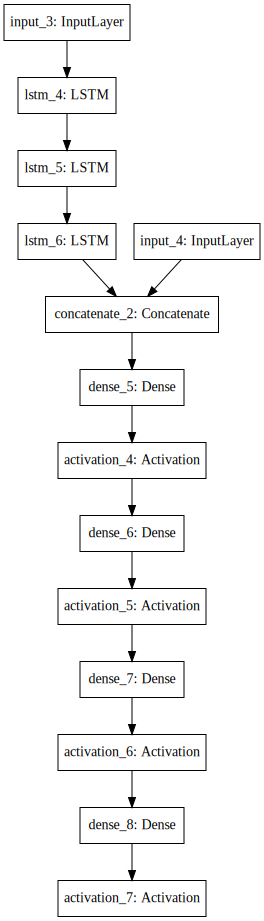

In [19]:
# Visualize
engine_length.model_summary(1, './figs/length_model.png')

In [46]:
engine_length.load_model('./models/length_model_run_noTB')

In [16]:
# Train
run_id = 'noTB'
engine_length.fit(30, early_stopping=True, verbose=1)

Epoch 1/30
120/120 [==============================] - 15s 128ms/step - loss: 1.6570 - categorical_accuracy: 0.4073 - val_loss: 1.4658 - val_categorical_accuracy: 0.4796
Epoch 2/30
120/120 [==============================] - 12s 98ms/step - loss: 1.4195 - categorical_accuracy: 0.4715 - val_loss: 1.3600 - val_categorical_accuracy: 0.4796
Epoch 3/30
120/120 [==============================] - 14s 114ms/step - loss: 1.3418 - categorical_accuracy: 0.4724 - val_loss: 1.3086 - val_categorical_accuracy: 0.4804
Epoch 4/30
120/120 [==============================] - 14s 116ms/step - loss: 1.3049 - categorical_accuracy: 0.4739 - val_loss: 1.2883 - val_categorical_accuracy: 0.4904
Epoch 5/30
120/120 [==============================] - 13s 111ms/step - loss: 1.2922 - categorical_accuracy: 0.4810 - val_loss: 1.2743 - val_categorical_accuracy: 0.4937
Epoch 6/30
120/120 [==============================] - 15s 122ms/step - loss: 1.2691 - categorical_accuracy: 0.4831 - val_loss: 1.2721 - val_categorical_accu

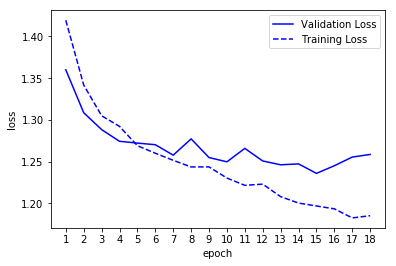

In [17]:
# Check out losses again
engine_length.plot_history(True, './figs/length_losses_run_{:s}.png'.format(str(run_id)), display=True)

In [18]:
# Predict for specific player
player_name = 'Mitchell Marner'
test = engine_length.predict(player_name, (4,7,2019), 0, verbose=True)

Length: 1 ** Probability: 0.020
Length: 2 ** Probability: 0.056
Length: 3 ** Probability: 0.025
Length: 4 ** Probability: 0.080
Length: 5 ** Probability: 0.177
Length: 6 ** Probability: 0.144
Length: 7 ** Probability: 0.046
Length: 8 ** Probability: 0.452

Most likely contract length:  8


In [25]:
# Save
engine_length.save_model('models/length_model_run_{:s}'.format(str(run_id)))

In [30]:
# Now do a bunch of runs with tensorboard on, save all the models and get an average estimate for one player
# For some reason TB doesn't work with this model. --> Fixed, it was just one of the callbacks
num_models = 20
num_epochs = 50
artemi_avg = np.empty(num_models)
print('Model Prediction for Artemi Panarin: ')
run_id = 0
for ii in range(num_models):
    K.clear_session()
    model_len = make_model(prediction_type = 'length', 
                       lstm_layers = [64, 64, 32], 
                       dense_layers= [20, 20, 20],
                       activation = 'relu')
    
    optim = Adam()
    
    engine = Engine(model_len, data_gen_length, optim, prediction_type = 'length')
    
    tensorboard=True
    base_dir = 'length_logs'
    if tensorboard:
        log_dir = os.path.join('./logs', base_dir)
        run_id = len([name for name in os.listdir(log_dir)])
    engine.fit(num_epochs, tensorboard=tensorboard, verbose=0)
    engine.plot_history(True, './figs/length_losses_run_{:s}.png'.format(str(run_id)), False)
    engine.save_model('models/length_model_run_{:s}'.format(str(run_id)))
    
    predictions = engine.predict('Artemi Panarin', (4,7,2019), 1, verbose=False)
    artemi_avg[ii] = np.argmax(predictions)+1
    
    print('Model: {:d} ** Length: {:d}'.format(run_id, np.argmax(predictions)+1))
    run_id+=1
    
print('Length Average: {:0.3f}'.format(np.mean(artemi_avg)))
print('Length Median: {:0.0f}'.format(np.median(artemi_avg)))
print('Length St Dev: {:0.3f}'.format(np.std(artemi_avg)))

Model Prediction for Artemi Panarin: 
Model: 0 ** Length: 8
Model: 1 ** Length: 8
Model: 2 ** Length: 8
Model: 3 ** Length: 8
Model: 4 ** Length: 8
Model: 5 ** Length: 8
Model: 6 ** Length: 8
Model: 7 ** Length: 8
Model: 8 ** Length: 8
Model: 9 ** Length: 8
Model: 10 ** Length: 8
Model: 11 ** Length: 8
Model: 12 ** Length: 8
Model: 13 ** Length: 8
Model: 14 ** Length: 8
Model: 15 ** Length: 8
Model: 16 ** Length: 8
Model: 17 ** Length: 8
Model: 18 ** Length: 5
Model: 19 ** Length: 8
Length Average: 7.850
Length Median: 8
Length St Dev: 0.654


In [ ]:
engine_cap.load_model('./models/cap_hit_model_run_noTB')
engine_length.load_model('./models/length_model_run_noTB')

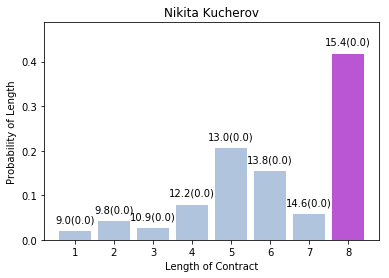

In [56]:
# Visualize Prediction Results For a Single Player
plot_results(player_name='Nikita Kucherov',
             signing_date=(5, 7, 2019),
             signing_status=0,
             engine_length=engine_length,
             engine_cap=engine_cap,
             save_file=False)

In [37]:
# Or use mutliple saved models to get a more statistical result
load_models = ['run_'+str(x) for x in range(20)]
load_models

['run_0',
 'run_1',
 'run_2',
 'run_3',
 'run_4',
 'run_5',
 'run_6',
 'run_7',
 'run_8',
 'run_9',
 'run_10',
 'run_11',
 'run_12',
 'run_13',
 'run_14',
 'run_15',
 'run_16',
 'run_17',
 'run_18',
 'run_19']

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000020FFF57F7B8>>
Traceback (most recent call last):
  File "C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\linds\Anaconda3\envs\datascience\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 2266906951752


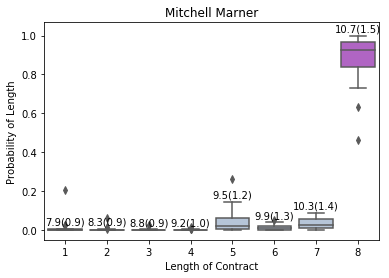

In [57]:
plot_results('Mitchell Marner', (5, 7, 2019), 0, engine_length, engine_cap, load_models = load_models)

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_results(player_name, signing_date, signing_status, engine_length, engine_cap, load_models=None,
                 save_file=True):
    # TODO reload a model at the very end so that it's not broken later
    """
    Plot the most likely contract length, with most likely contract sizes as well
    :param player_name: player name of interest
    :param signing_date: player signing date, (day, month, year)
    :param signing_status: 0 (RFA) or 1 (UFA)
    :param engine_length: engine that stores length models/data
    :param engine_cap: engine that stores cap hit models/data
    :param load_models: list of models to load into the engines.
                        should be a list of strings that will have length_model_ or cap_hit_model_
                        prepended to get the full path
                        assumes they are in the ./models/ folder, and that they end with .h5
    :param save_file: if true saves file to ./figs/player_name
    :return: nice lil plot
    """

    # Get the length predictions
    _, ax = plt.subplots()
    if load_models is None:
        lengths = engine_length.predict(player_name, signing_date, signing_status, verbose=False)
        max_height = np.max(lengths) + 0.07
        plt.bar(range(0, len(lengths)), lengths, color='lightsteelblue')
        plt.bar(np.argmax(lengths), np.max(lengths), color='mediumorchid')
        min_height = 0
    else:
        palette = ['lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue', 'lightsteelblue',
                   'lightsteelblue', 'lightsteelblue', 'lightsteelblue']
        base = './models/length_model_'
        lengths_all = [[], [], [], [], [], [], [], []]
        for ii, ext in enumerate(load_models):
            K.clear_session()
            model_file = base + ext 
            engine_length.load_model(model_file)
            lengths_model_x = engine_length.predict(player_name, signing_date, signing_status, verbose=False)
            for jj in range(8):
                lengths_all[jj].append(lengths_model_x[jj])
        # lengths = np.mean(lengths_all, axis=1)
        # yerr = np.std(lengths_all, axis=1)
        # height = lengths+yerr
        # max_height = np.max(height)+0.07
        interquartile_range = np.percentile(lengths_all, 75, axis=1) - np.percentile(lengths_all, 25, axis=1)
        third_quartile = np.percentile(lengths_all, 75, axis=1)
        fences = third_quartile + 1.5 * interquartile_range
        median = np.median(lengths_all, axis=1)
        lengths = []
        # find height of upper whisker
        for kk, fence in enumerate(fences):
            lengths_kk = lengths_all[kk]
            best = 0
            for x in lengths_kk:
                if (x < fence) & (x > best):
                    best = x
            lengths.append(best)

        palette[int(np.argmax(median))] = 'mediumorchid'
        sns.boxplot(data=lengths_all, palette=palette)
        max_height = np.max(lengths) + 0.07
        min_height = -0.05

    # Plot the lengths as a bar plot
    # plt.plot(range(1, len(lengths) + 1), lengths, color='red')
    plt.xlabel('Length of Contract')
    plt.ylabel('Probability of Length')
    ax.set_xticks(range(8))
    ax.set_xticklabels(range(1, 9))
    plt.ylim([min_height, max_height])
    plt.title(player_name)

    # Get the cap prediction for each length
    for length in range(1, 9):
        if load_models is None:
            cap_hit, _ = engine_cap.predict(player_name, signing_date, signing_status, length, verbose=False)
            cap_hit_std = 0
        else:
            base = './models/cap_hit_model_'
            cap_hit_all = np.empty(len(load_models))
            for ii, ext in enumerate(load_models):
                K.clear_session()
                model_file = base + ext
                engine_cap.load_model(model_file)
                cap_hit_all[ii], _ = engine_cap.predict(player_name, signing_date, signing_status, length,
                                                        verbose=False)
            cap_hit = np.mean(cap_hit_all)
            cap_hit_std = np.std(cap_hit_all)

        cap_hit = cap_hit / 1e6
        cap_hit_std = cap_hit_std / 1e6
        ax.text(length - 1, lengths[length - 1] + 0.02, '{:0.1f}({:0.1f})'.format(cap_hit, cap_hit_std),
                horizontalalignment='center')

    if save_file:
        plt.savefig('./figs/' + player_name.lower().replace(' ', '_') + '.png', bbox_inches='tight')
    plt.show()
